# Example of using korina to augment keypoints
In this example, we will use kornia to augment keypoints.

In [1]:
import json
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import kornia as K
from kornia import augmentation as A
from kornia.augmentation import AugmentationSequential
import matplotlib.pyplot as plt

# if cuda is avaliable, use it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

images_path = '../dataset/train/images'
annotations_path = '../dataset/train/annotations'

cuda


Method to translate format from json to kornia and vice versa


In [36]:
def convert_to_kornia_format(data):
    # Extract the bounding boxes and keypoints from the dictionary
    bboxes = data['bboxes']
    keypoints = data['keypoints']

    # Convert the bounding boxes to the Kornia format
    bbox_list = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        bbox_list.append([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])
    bbox_tensor = torch.tensor(bbox_list).unsqueeze(0)

    # Convert the keypoints to the Kornia format
    keypoint_list = []
    for kpts in keypoints:
        for kpt in kpts:
            x, y, _ = kpt
            keypoint_list.append([x, y])
    keypoint_tensor = torch.tensor(keypoint_list).unsqueeze(0)

    return bbox_tensor, keypoint_tensor

In [58]:
def kornia_to_torch_format(bbox_tensor, keypoint_tensor, labels=None):
    """
    Convert bbox_tensor and keypoint_tensor in Kornia format to torch's expected format.
    
    Parameters:
    - bbox_tensor (torch.Tensor): Bounding box tensor in Kornia format
    - keypoint_tensor (torch.Tensor): Keypoint tensor in Kornia format
    - labels (list[int]): List of class labels for each bounding box. If None, default to label=1 for all boxes.
    
    Returns:
    - dict: A dictionary with 'boxes', 'labels', and 'keypoints' in the format expected by torch.
    """
    # Convert bbox_tensor from Kornia's format to torch's [x1, y1, x2, y2] format
    boxes = torch.stack([bbox_tensor[0,:,0,0], bbox_tensor[0,:,0,1], bbox_tensor[0,:,2,0], bbox_tensor[0,:,2,1]], dim=1)
    
    # If labels aren't provided, assume a default label of 1 for all bounding boxes
    if labels is None:
        labels = torch.ones((bbox_tensor.shape[1],), dtype=torch.int64)
    else:
        labels = torch.tensor(labels, dtype=torch.int64)
    
    # Convert keypoint_tensor to the desired [x, y, visibility] format
    keypoints = torch.zeros((bbox_tensor.shape[1], keypoint_tensor.shape[1]//bbox_tensor.shape[1], 3))
    for i in range(bbox_tensor.shape[1]):
        keypoints[i, :, :2] = keypoint_tensor[0, i*2:(i+1)*2, :]
        keypoints[i, :, 2] = 1  # setting visibility to 1
    
    return {"boxes": boxes, "labels": labels, "keypoints": keypoints}



First let's go to load image and annotations from the dataset. 

In [60]:
# get all images in the folder using os
image_filenames = [filename for filename in os.listdir(images_path) if filename.endswith('.jpg')]

for image_filename in image_filenames:
    image = cv2.imread(os.path.join(images_path, image_filename))
    annotation_filename = os.path.join(annotations_path, image_filename[:-4] + '.json')
    with open(annotation_filename, 'r') as f:
        annotation = json.load(f)
    print('JSON:')    
    print(annotation)
    print('-'*200)
    print('Kornia')
    bbox_tensor, keypoint_tensor = convert_to_kornia_format(annotation)
    print(bbox_tensor)
    print(keypoint_tensor)
    print('-'*200)
    print('Training:') 
    targets = kornia_to_torch_format(bbox_tensor, keypoint_tensor)
    print(targets)
    break
    

JSON:
{'bboxes': [[692, 346, 904, 504], [1076, 364, 1236, 572]], 'keypoints': [[[881, 479, 1], [709, 372, 1]], [[1212, 387, 1], [1102, 552, 1]]]}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Kornia
tensor([[[[ 692,  346],
          [ 904,  346],
          [ 904,  504],
          [ 692,  504]],

         [[1076,  364],
          [1236,  364],
          [1236,  572],
          [1076,  572]]]])
tensor([[[ 881,  479],
         [ 709,  372],
         [1212,  387],
         [1102,  552]]])
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Training:
{'boxes': tensor([[ 692,  346,  904,  504],
        [1076,  364, 1236,  572]]), 'labels': tensor([1, 1]), 'keypoints': tensor([[[8.8100e+02, 4.7

Plot the image and the keypoints using json

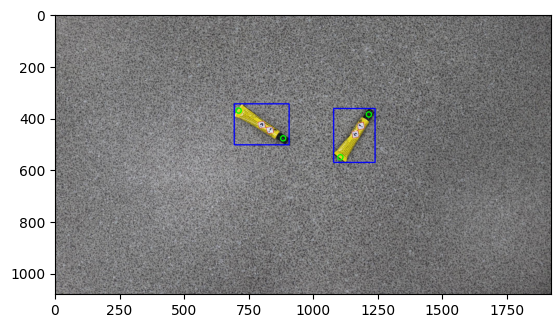

In [5]:

# Define the colors for the bounding boxes and keypoints
bbox_color = (255, 0, 0) # blue
keypoint_color = (0, 255, 0) # green

# Extract the bounding boxes and keypoints from the dictionary
bboxes = annotation['bboxes']
keypoints = annotation['keypoints']

# Draw the bounding boxes and keypoints on the image
for bbox, kpts in zip(bboxes, keypoints):
    x1, y1, x2, y2 = bbox
    cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, thickness=3)
    for kpt in kpts:
        x, y, _ = kpt
        cv2.circle(image, (x, y), radius=10, color=keypoint_color, thickness=3)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

We are going to use kornia to augment the dataset

In [6]:
 # convert to tensor
image_tensor: torch.Tensor = K.image_to_tensor(image)

# bgr to rgb
image_tensor = K.color.bgr_to_rgb(image_tensor)

image_tensor = K.enhance.normalize(image_tensor, torch.tensor(0.), torch.tensor(255.)).to(device)

print(image_tensor.shape)

torch.Size([3, 1080, 1920])


Method to plot kornia keypoints on image.

In [19]:
def plot_resulting_image(img, bbox, keypoints):
    img_array = K.tensor_to_image(img.mul(255).byte()).copy()
    img_draw = cv2.polylines(img_array, bbox.reshape(-1, 4, 2).numpy(), isClosed=True, color=(255, 0, 0))
    for k in keypoints[0]:
        img_draw = cv2.circle(img_draw, tuple(k.numpy()[:2]), radius=6, color=(255, 0, 0), thickness=-1)
    return img_draw

Define augmentation

In [20]:
aug_list = AugmentationSequential(
    K.augmentation.ColorJitter(0.1, 0.1, 0.1, 0.1, p=1.0),
    K.augmentation.RandomHorizontalFlip(p=0.5),
    K.augmentation.RandomVerticalFlip(p=0.5),
    K.augmentation.RandomRotation(degrees=360, p=1.0),
    data_keys=["input", "bbox", "keypoints"],
    same_on_batch=False,
)

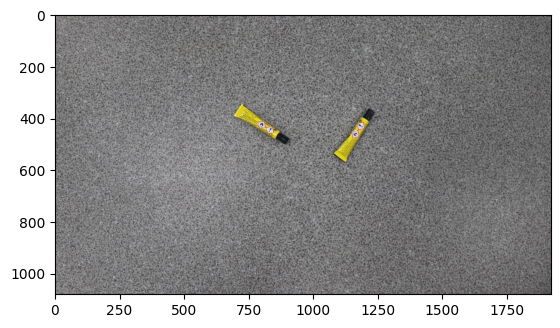

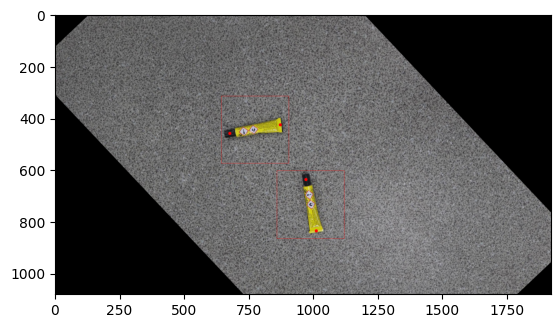

In [35]:
for image_filename in image_filenames:
    image = cv2.imread(os.path.join(images_path, image_filename))
    image_tensor: torch.Tensor = K.image_to_tensor(image)
    # bgr to rgb
    image_tensor = K.color.bgr_to_rgb(image_tensor)
    image_tensor =  K.enhance.normalize(image_tensor, torch.tensor(0.), torch.tensor(255.))

    annotation_filename = os.path.join(annotations_path, image_filename[:-4] + '.json')
    with open(annotation_filename, 'r') as f:
        bbox_tensor, keypoint_tensor = convert_to_kornia_format(json.load(f))
    
    out_tensor = aug_list(image_tensor.float(), bbox_tensor.float(), keypoint_tensor.float())
    img_out = plot_resulting_image(
        out_tensor[0][0],
        out_tensor[1].int(),
        out_tensor[2].int(),
    )
    # plot the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(img_out)
    plt.show()
    break